In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc #ガベージコレクション 不要になったメモリ領域を自動的に解放する機能

import lightgbm as lgb

from sklearn.metrics import roc_auc_score,accuracy_score #ROC曲線の下の面積（AUC）を計算する関数と、分類精度を計算する関数をインポートします。これらはモデルの性能評価に使用されます
from sklearn.metrics import classification_report #精度、適合率、再現率、F1スコアなどの詳細な分類レポートを生成する関数をインポート
from sklearn.metrics import confusion_matrix #混同行列を計算する関数をインポートします。誤分類のパターンを視覚化するために使用されます。

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from scipy.stats import mode #最頻値を計算する関数をインポートします。データの最も頻繁に現れる値を計算するために使用

import warnings
warnings.filterwarnings("ignore") #警告メッセージを無視するように設定します。不要な警告メッセージを非表示にして、出力を見やすくします

pd.set_option('display.max_columns', None) #Pandasデータフレームの表示設定を変更します。すべての列を表示するように設定します

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")
submit = pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")

In [4]:
train

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,76513,1,17,1,9254,1,1,121.0,1,19,1,7,5,116.5,1,0,0,1,0,1,18,0,0,6,9,6,10.666667,0,0,6,8,5,10.600000,0,13.9,-0.3,0.79,Graduate
76514,76514,1,1,6,9254,1,1,125.0,1,1,38,4,9,131.6,1,0,0,1,0,0,19,0,0,6,22,4,13.000000,0,0,6,9,6,13.875000,0,9.4,-0.8,-3.12,Graduate
76515,76515,5,17,1,9085,1,1,138.0,1,37,37,9,10,123.3,1,0,0,1,0,0,19,0,0,5,13,4,12.500000,2,0,5,8,5,11.400000,1,9.4,-0.8,-3.12,Enrolled
76516,76516,1,1,3,9070,1,1,136.0,1,38,37,5,9,124.8,1,0,0,1,0,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,7.6,2.6,0.32,Dropout


In [5]:
test

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.0,1,3,1,2,3,152.1,0,0,0,0,0,0,18,0,0,7,0,0,0.000000,0,0,8,0,0,0.000000,0,13.9,-0.3,0.79
1,76519,1,1,1,9238,1,1,128.0,1,1,19,4,5,116.5,0,0,0,1,0,0,19,0,0,6,7,6,14.857143,0,0,6,6,6,13.500000,0,11.1,0.6,2.02
2,76520,1,1,1,9238,1,1,118.0,1,1,19,4,9,114.2,0,0,0,1,0,1,18,0,0,6,11,6,12.000000,0,0,6,11,5,11.000000,0,15.5,2.8,-4.06
3,76521,1,44,1,9147,1,39,130.0,1,1,19,3,3,130.0,0,0,0,1,0,1,23,0,2,6,15,5,11.500000,0,3,8,14,5,11.000000,0,8.9,1.4,3.51
4,76522,1,39,1,9670,1,1,110.0,1,1,37,5,5,106.0,1,0,0,1,0,0,26,0,0,6,9,3,11.000000,0,0,6,9,4,10.666667,2,7.6,2.6,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,127525,1,1,2,171,1,1,128.0,1,38,37,7,10,124.7,1,0,0,1,0,0,19,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,15.5,2.8,-4.06
51008,127526,2,39,1,9119,1,19,133.1,1,19,37,9,9,140.0,0,0,1,0,1,0,33,0,0,5,6,0,0.000000,0,0,5,5,0,0.000000,0,9.4,-0.8,-3.12
51009,127527,1,1,1,171,1,1,127.0,1,1,1,4,10,120.4,0,0,1,0,0,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,15.5,2.8,-4.06
51010,127528,1,1,3,9773,1,1,132.0,1,19,19,5,5,126.3,1,0,1,0,0,0,18,0,0,6,8,5,12.600000,0,0,6,9,3,13.000000,0,7.6,2.6,0.32


In [6]:
submit

,id,Target
0,76518,Graduate
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Graduate
...,...,...
51007,127525,Graduate
51008,127526,Graduate
51009,127527,Graduate
51010,127528,Graduate


In [7]:
train.isnull().sum()

id                                                0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship 

In [8]:
train.dtypes

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees u

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Marital status'}>,
        <Axes: title={'center': 'Application mode'}>,
        <Axes: title={'center': 'Application order'}>,
        <Axes: title={'center': 'Course'}>,
        <Axes: title={'center': 'Daytime/evening attendance'}>],
       [<Axes: title={'center': 'Previous qualification'}>,
        <Axes: title={'center': 'Previous qualification (grade)'}>,
        <Axes: title={'center': 'Nacionality'}>,
        <Axes: title={'center': "Mother's qualification"}>,
        <Axes: title={'center': "Father's qualification"}>,
        <Axes: title={'center': "Mother's occupation"}>],
       [<Axes: title={'center': "Father's occupation"}>,
        <Axes: title={'center': 'Admission grade'}>,
        <Axes: title={'center': 'Displaced'}>,
        <Axes: title={'center': 'Educational special needs'}>,
        <Axes: title={'center': 'Debtor'}>,
        <Axes: title={'center': 'Tuition fees up to date'}>],
       [<

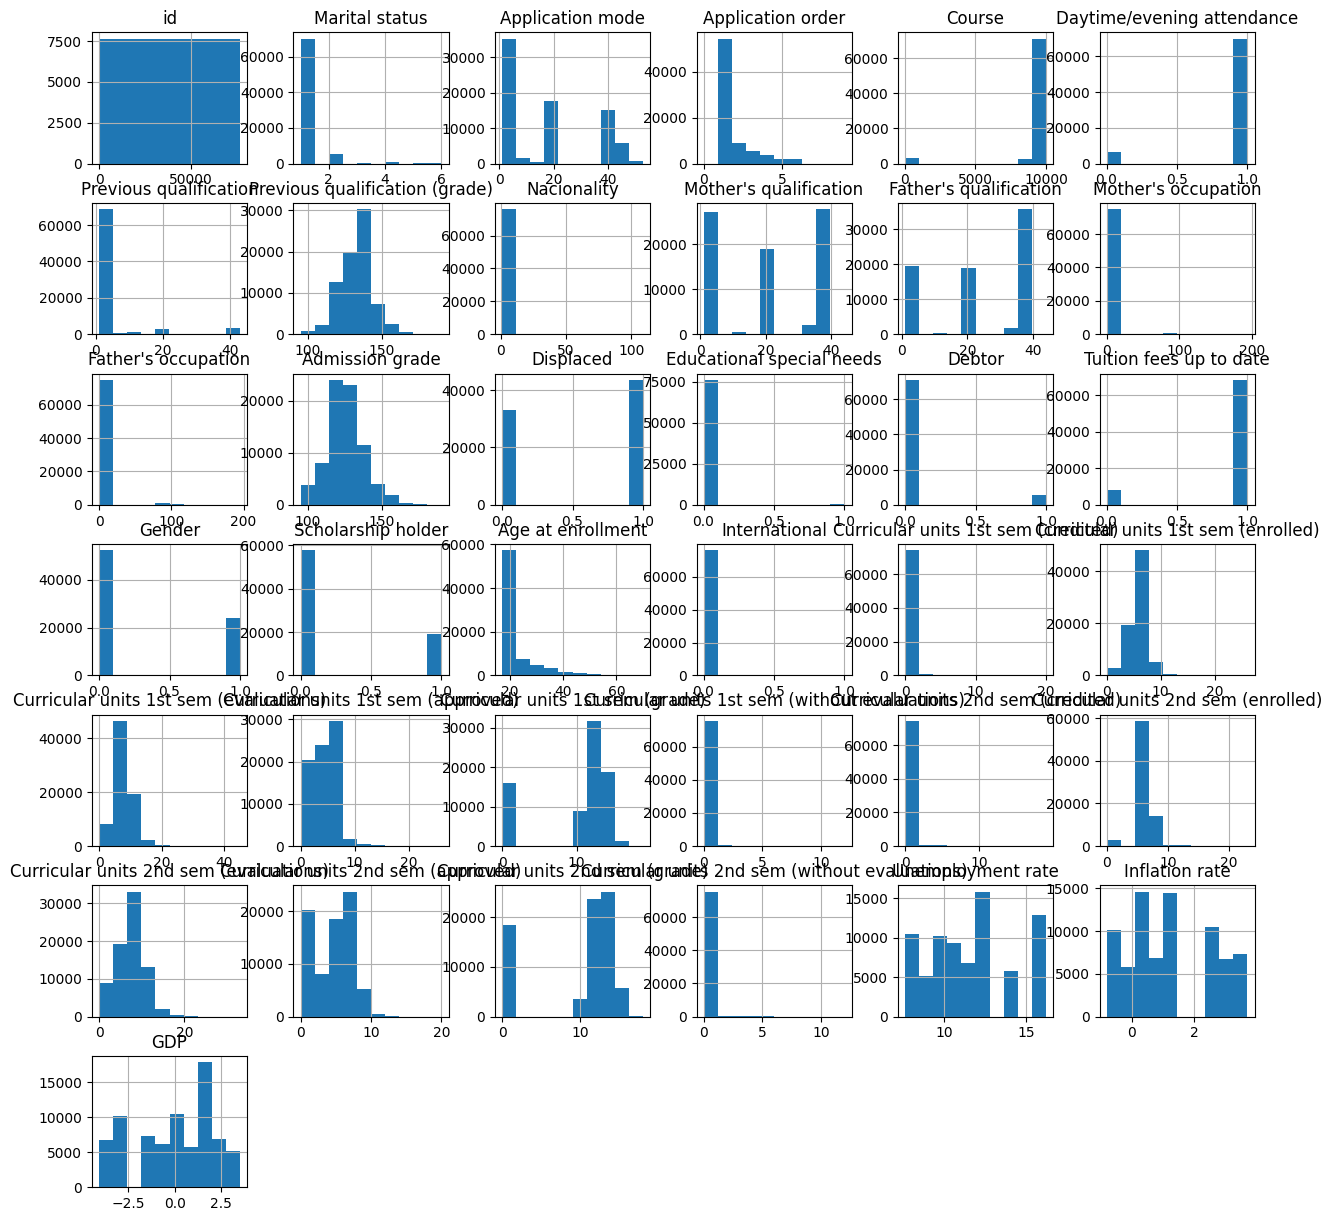

In [9]:
#trainデータフレームの各列に対するヒストグラムを作成し、15x15インチの図を表示
fig, ax = plt.subplots(figsize=(15,15)) #fig は図全体（Figure）を表します。 ax は軸（Axes）オブジェクトで、プロットを描画するための領域です
train.hist(ax=ax) #ax=ax を指定することで、先ほど作成した軸オブジェクト ax を使用してヒストグラムを描画します。これにより、すべてのヒストグラムが同じ図（Figure）内に描画されます。

In [10]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [11]:
x = train.drop('Target', axis = 1)
t = train['Target']
x_test = test

In [12]:
x.shape, t.shape, x_test.shape

((76518, 36), (76518,), (51012, 36))

In [13]:
le = LabelEncoder()
t = le.fit_transform(t) #ラベルエンコーディングにし、質的データを量的データに変換

In [14]:
t

array([2, 0, 0, ..., 1, 0, 2])

**モデルのトレーニング**

**パラメータ　optuna使用**

In [15]:
params = {'n_estimators': 8000, #作成するブースティングツリーの最大数
          'num_class': 3, #多クラス分類問題におけるクラスの数
          'boosting_type': 'gbdt', #ブースティングのタイプ。'gbdt' は勾配ブースティング決定木 (Gradient Boosting Decision Tree) 
          'objective': 'multiclass', #目的関数。ここでは多クラス分類を指定
          'metric': 'multi_logloss', #モデルの性能を評価する指標。多クラス分類においてログ損失（log loss）を使用　低いほど精度良い
          'verbosity': -1, #ログの詳細度。-1 は全てのメッセージを非表示
          'random_state': 99, #乱数シード
          'reg_alpha': 1.7878527151970849,  #L1正則化の強さ。L1正則化は過学習を防ぐために使用
          'reg_lambda': 1.391543710164331,  #L2正則化の強さ
          'colsample_bytree': 0.5, #各ツリーの構築に使用する特徴量の割合
          'subsample': 0.5, #各ツリーの構築に使用するデータの割合
          'learning_rate': 0.04, #学習率
          'max_depth': 20, #各決定木の最大深さ。ここでは20と設定されています。深すぎると過学習のリスクがありますが、浅すぎると学習不足のリスクがあります。
          'num_leaves': 70, #各決定木におけるリーフの最大数。リーフの数が多いとモデルはより複雑になります。
          'min_child_samples': 40, #各リーフが持つべき最小データ数。この値が大きいほど過学習のリスクが減少します。
          'min_data_per_groups': 16 #データの各グループが持つべき最小データ数。過学習を防ぐために使用されます。
         }

In [16]:
#x:学習データの説明変数 t:学習データの目的変数
def cross_val_train(x, t, test, params): #cross_val_trainという名前の関数を定義しています。この関数は、トレーニングデータ (x, t) とテストデータ (x_test)、およびモデルのパラメータ (params) を引数として取ります
    
    spl=10   # Number of folders 交差検証のためのフォルダ数（分割数）を10に設定しています。
    
    #予測結果の初期化: テストデータと検証データの予測結果を保存するための配列を初期化しています。また、検証スコアとトレーニングスコアを保存するためのリストも初期化しています
    # Inititate arrays with predictions and oof predictions
    test_preds = np.zeros((len(x_test),3))
    val_preds = np.zeros((len(x),3))
    val_scores, train_scores = [],[]
    
   #KFoldクラスを使って、データを交差検証用に分割します。データをシャッフルし、ランダムシードを42に設定しています
    #cv.split(x, t) によってデータ x とターゲット t をトレーニングインデックス (train_ind) と検証インデックス (valid_ind) に分割します。enumerate を使って、フォルドの番号 (fold) も取得します。このループは、交差検証の各フォルドについて実行されます。
    # perform cross-validation split
    cv = KFold(spl, shuffle=True, random_state=42)
    
    #フォルドごとのトレーニングループ: 各フォルドについてトレーニングと検証を行うためのループを開始します。cv.split(X, y)でデータをトレーニングセットと検証セットに分割します。
    # "for" cycle to train for each fold
    for fold, (train_index, valid_index) in enumerate(cv.split(x,t)):
        #enumerate: ループ内でインデックス（ここではフォルド番号）と要素を同時に取得するために使用
        #cv.split(x, t): KFold インスタンスの split メソッドを呼び出し、特徴量データ x とターゲットデータ t をトレーニングインデックスと検証インデックスに分割します。
        #これにより、各フォルドごとに異なるトレーニングセットと検証セットが得られます。
        
        #データの分割: トレーニングインデックスと検証インデックスを使って、トレーニングデータと検証データを分割します。
        # divide train and validation data
        x_train = x.iloc[train_index] #トレーニングインデックスに基づいて、特徴量データ x からトレーニングセットを抽出します。
        t_train = t[train_index] #トレーニングインデックスに基づいて、ターゲットデータ t からトレーニングセットを抽出します。
        x_val = x.iloc[valid_index] #検証インデックスに基づいて、特徴量データ x から検証セットを抽出します。
        t_val = t[valid_index] #検証インデックスに基づいて、ターゲットデータ t から検証セットを抽出します。
        
        #渡されたパラメータを使って、LightGBMの分類器を初期化します。
        # Initiate model lightGBM 
        model = lgb.LGBMClassifier(**params)
        
        #トレーニングデータでモデルをトレーニングします。検証データセットを指定し、アーリーストッピングとログ出力のコールバックを設定しています。
        # fit the model
        model.fit(x_train, t_train, #訓練データ
                    eval_set=[(x_val, t_val)], #early_stopping用
                    callbacks=[lgb.early_stopping(stopping_rounds=70), lgb.log_evaluation(100)]) 
        
        #トレーニングデータと検証データに対して予測を行います。予測は確率として出力されます。
        # predictions on train and validation data
        t_pred_trn = model.predict_proba(x_train) #model.predict_proba は分類モデルにおいて各クラスに属する確率を予測するためのメソッドです。具体的には、与えられた入力データに対して、各クラスの予測確率を返します。
        t_pred_val = model.predict_proba(x_val)
        
        #トレーニングデータと検証データの精度を計算します。確率から最も高いクラスを選び、精度スコアを算出します。
        # compute accuracy
        train_acc = accuracy_score(t_train, np.argmax(t_pred_trn, axis=1))
        val_acc = accuracy_score(t_val, np.argmax(t_pred_val, axis=1))
        
        #各フォルドのトレーニング精度と検証精度を表示します。
        # print partial results for the fold
        print("Fold:",fold, " Train R2:",np.round(train_acc,5), " Val R2:",np.round(val_acc,5))
        
        #テストデータの予測を行い、全てのフォルドの平均を計算します。また、検証データの予測を保存し、検証スコアをリストに追加します
        # compute test predictions and oof predictions
        test_preds += model.predict_proba(test[test.columns])/spl #テストデータに対して各クラスに属する確率を予測します。ここで test.columns はテストデータの全ての列（特徴量）を指定しています。 / spl: 各フォルドで得られた予測確率を spl（交差検証の分割数）で割ります。これにより、全てのフォルドの予測を平均する準備をします。
        val_preds[valid_index] = model.predict_proba(x_val)
        val_scores.append(val_acc)
        print("-"*50)
    
    #結果の返却: 交差検証の検証スコア、検証データの予測、テストデータの予測を返します。
    return val_scores, val_preds, test_preds

In [17]:
val_scores, val_preds, test_preds = cross_val_train(x, t, test, params)

Training until validation scores don't improve for 70 rounds
[100]	valid_0's multi_logloss: 0.444556
[200]	valid_0's multi_logloss: 0.431929
[300]	valid_0's multi_logloss: 0.430148
[400]	valid_0's multi_logloss: 0.429985
Early stopping, best iteration is:
[337]	valid_0's multi_logloss: 0.429761
Fold: 0  Train R2: 0.87301  Val R2: 0.83495
--------------------------------------------------
Training until validation scores don't improve for 70 rounds
[100]	valid_0's multi_logloss: 0.432849
[200]	valid_0's multi_logloss: 0.420858
[300]	valid_0's multi_logloss: 0.419334
[400]	valid_0's multi_logloss: 0.419327
Early stopping, best iteration is:
[339]	valid_0's multi_logloss: 0.419102
Fold: 1  Train R2: 0.87267  Val R2: 0.83691
--------------------------------------------------
Training until validation scores don't improve for 70 rounds
[100]	valid_0's multi_logloss: 0.423393
[200]	valid_0's multi_logloss: 0.412187
[300]	valid_0's multi_logloss: 0.410563
Early stopping, best iteration is:
[2

**モデルの精度を計算**

In [18]:
val_preds_out = np.argmax(val_preds, axis=1)
accuracy_score(t, val_preds_out)

0.8336339162027235

**予測を行う**

In [19]:
t_test=np.argmax(test_preds, axis=1)
t_test

array([0, 2, 2, ..., 0, 0, 0])

In [20]:
t_test = le.inverse_transform(t_test)

In [21]:
t_test

array(['Dropout', 'Graduate', 'Graduate', ..., 'Dropout', 'Dropout',
       'Dropout'], dtype=object)

In [22]:
submit["Target"] = t_test

In [23]:
submit.to_csv('submit_accademic_success.csv',index=False)

In [24]:
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [25]:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./__notebook__.ipynb
./submit_accademic_success.csv
